In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as kearas
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
interpreter = tf.lite.Interpreter("C:/Users/hjhhi/Desktop/Codes/lite-model_movenet_singlepose_lightning_tflite_float16_4.tflite")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.allocate_tensors()
output = interpreter.get_output_details()[0]  # Model has single output.
input = interpreter.get_input_details()[0]  # Model has single input.

In [3]:
interpreter.invoke()


image = cv2.imread("C:/Users/hjhhi/Desktop/Codes/51.jpg")
image= image.astype("uint8")
image = cv2.resize(image, (192, 192), interpolation=cv2.INTER_NEAREST)
image= np.resize(image, (1, 192, 192, 3))

interpreter.set_tensor(input['index'], image)
interpreter.invoke()
result = interpreter.get_tensor(output_details[0]['index'])

In [4]:
image_to_show = cv2.imread("C:/Users/hjhhi/Desktop/Codes/51.jpg")
image_to_show = temp = cv2.cvtColor(image_to_show, cv2.COLOR_BGR2RGB)
image_to_show = cv2.resize(image_to_show, (192, 192))

In [5]:
result

array([[[[0.28111398, 0.5317888 , 0.47765046],
         [0.25310028, 0.5673887 , 0.5779915 ],
         [0.25134215, 0.49615565, 0.50343144],
         [0.28753802, 0.60212123, 0.54144037],
         [0.28301546, 0.44190913, 0.46768877],
         [0.4671161 , 0.64368135, 0.4510767 ],
         [0.4372622 , 0.3951005 , 0.57529557],
         [0.23595968, 0.7329948 , 0.4379378 ],
         [0.3312919 , 0.39459828, 0.15430428],
         [0.17209376, 0.58653116, 0.4120164 ],
         [0.1524596 , 0.45629707, 0.3945312 ],
         [0.97939146, 0.61625224, 0.2519419 ],
         [0.98639065, 0.4413308 , 0.26698625],
         [0.94686204, 0.6194814 , 0.09976839],
         [0.9048511 , 0.4107878 , 0.06130492],
         [0.9609987 , 0.44190702, 0.01156833],
         [0.99914026, 0.3356763 , 0.03061385]]]], dtype=float32)

In [6]:
result.shape

(1, 1, 17, 3)

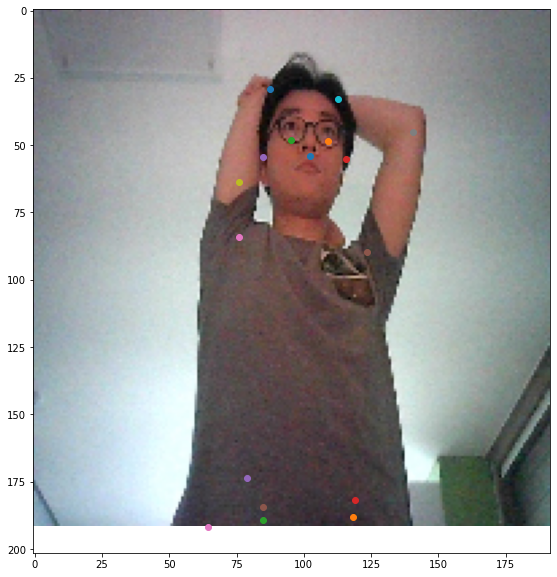

In [7]:
plt.figure(figsize=(14, 10))
plt.imshow(image_to_show)
for i in result[0][0]:
    plt.scatter(i[1]*192, i[0]*192)

# Make dataset for train

In [8]:
def make_image(size_1=32, size_2 = 32):
    path = "C:/Users/hjhhi/Downloads/image"
    y=[]
    data = []
    for i in os.listdir(path):
        for j in os.listdir(os.path.join(path, i)):
            temp = cv2.imread(os.path.join(path, i, j))
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
            temp = cv2.resize(temp, (size_1, size_2))
            data.append(temp)
            y.append(int(i))#Append int converting
    data = np.uint8(data)
    return data, y

In [9]:
X_for_visualize, y_for_visualize = make_image(640, 480)

In [10]:
X, y = make_image(192, 192)

In [11]:
X_ = []
for i in range(len(X)):
    input_data = X[i]
    interpreter.invoke()
    interpreter.set_tensor(input['index'], [input_data])
    X_.append(interpreter.get_tensor(output_details[0]['index']))
X_ = np.array(X_).reshape(len(X_), 51)

X: image resized by 192 for te_lite  
y: label for stretching pose  
X_: nparray returned by tflite by X
X_for_visualize: 480x640 image for visualize
X_train, X_test, y_train, y_test:   
모델 학습을 위하여 nparray를 쪼갬(이미지가 아니라는 점에 주의)

# Visualize dataset

In [12]:
def show(num=0):
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.imshow(X[num])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for i in range(17):
#         if X_[num][2+i*3] < 0.5:
#             continue
        ax.scatter(X_[num][1+i*3]*192, X_[num][0+i*3]*192)

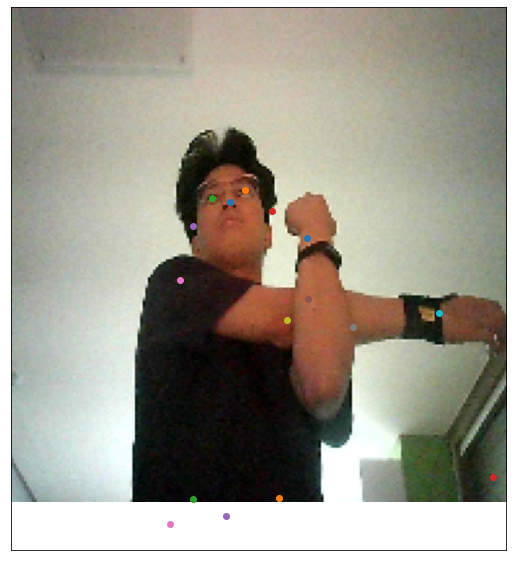

In [13]:
show(15)

In [14]:
def show_high(num=0):
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.imshow(X_for_visualize[num])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for i in range(17):
#         if X_[num][2+i*3] < 0.5:
#             continue
        ax.scatter(X_[num][1+i*3]*640, X_[num][0+i*3]*480)

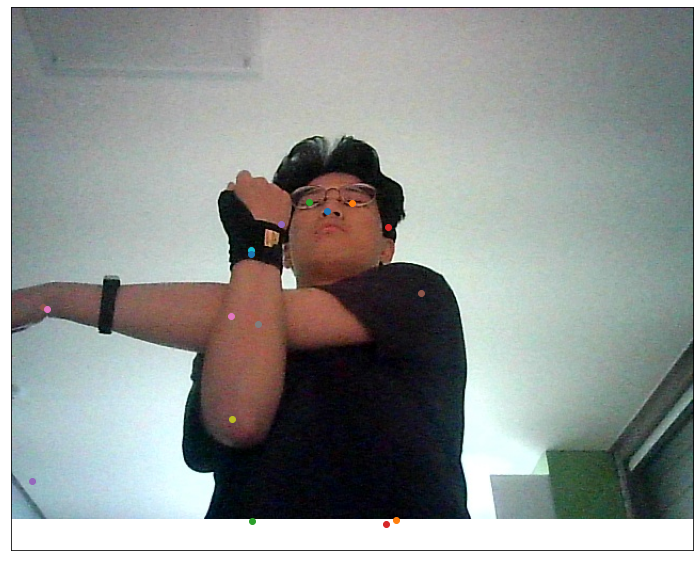

In [15]:
show_high(150)

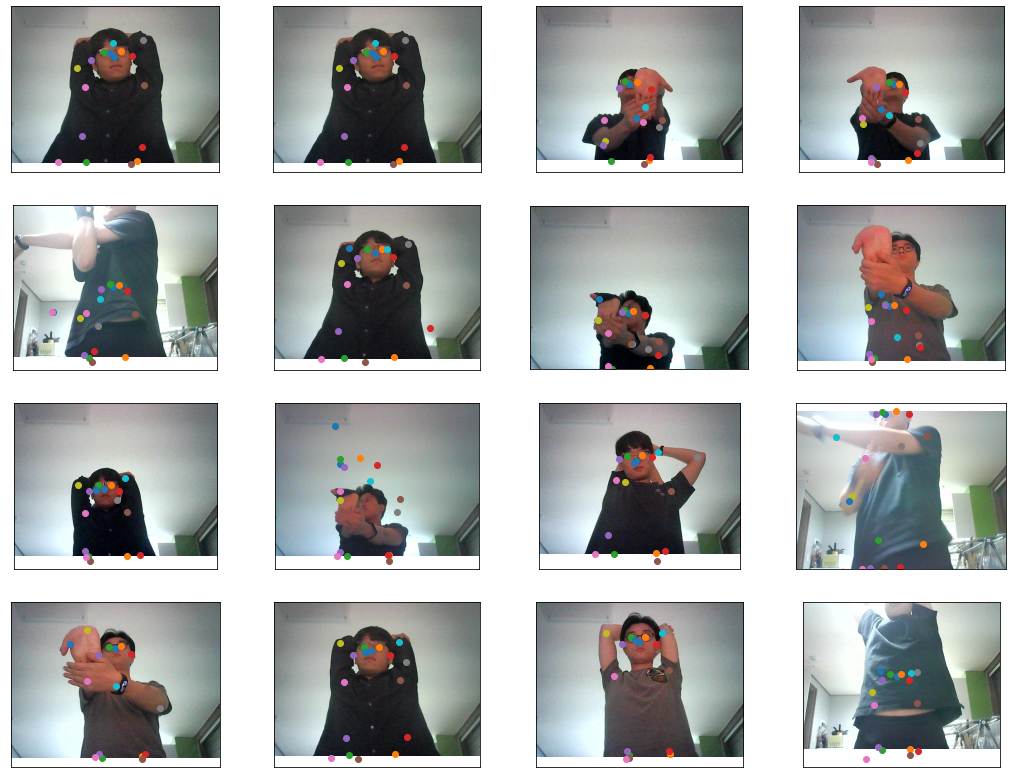

In [16]:
fig, ax = plt.subplots(4, 4, figsize=(18, 14))
for i in range(4):
    for j in range(4):
        index = np.random.randint(0, len(X_for_visualize))
        ax[i, j].xaxis.set_visible(False)
        ax[i, j].yaxis.set_visible(False)
        ax[i, j].imshow(X_for_visualize[index])
        for k in range(17):
            ax[i, j].scatter(X_[index][1+k*3]*640, X_[index][0+k*3]*480)

# Tuning model

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_, y)

In [18]:
model = RandomForestClassifier(n_estimators=50, max_depth=6)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9826086956521739

In [19]:
%%time
model.predict([X_[500]])

CPU times: total: 15.6 ms
Wall time: 5 ms


array([4])

# Predict_proba

In [20]:
def image_preprocess(path):
    image = cv2.imread(path)
    image= image.astype("uint8")
    image = cv2.resize(image, (192, 192), interpolation=cv2.INTER_NEAREST)
    image= np.resize(image, (1, 192, 192, 3))
    return image

In [21]:
image_for_predict = image_preprocess("C:/Users/hjhhi/Downloads/image/4/136.jpg")

In [22]:
interpreter.set_tensor(input['index'], image_for_predict)
interpreter.invoke()
result = interpreter.get_tensor(output_details[0]['index'])

In [23]:
result

array([[[[0.6466163 , 0.52353513, 0.12329142],
         [0.6177834 , 0.52401847, 0.10780808],
         [0.61945844, 0.5060079 , 0.10615409],
         [0.64408064, 0.5263611 , 0.16046786],
         [0.64753425, 0.47331047, 0.11102688],
         [0.7441772 , 0.5224859 , 0.12710929],
         [0.7397147 , 0.46122977, 0.10179761],
         [0.8178041 , 0.55803543, 0.29821914],
         [0.7269291 , 0.45791194, 0.07662102],
         [0.67623836, 0.505233  , 0.1561973 ],
         [0.6819003 , 0.4932895 , 0.10091307],
         [0.8544883 , 0.5080931 , 0.04339637],
         [0.85729325, 0.43145224, 0.05410573],
         [0.8008661 , 0.55898184, 0.21893032],
         [0.8038605 , 0.55156535, 0.17187646],
         [0.84892184, 0.54874456, 0.03985028],
         [0.8750658 , 0.5078314 , 0.03125991]]]], dtype=float32)